### Imports

In [1]:
import png
import random
import numpy as np
import json
import tensorflow as tf
from IPython import display
from pathlib import Path


2023-04-21 20:19:32.050976: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 20:19:32.251562: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 20:19:32.252804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 20:19:33.585478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load image

In [2]:
file_name = 'y/G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004.raw'
file_name_core = 'G_684_2019_500mGy_Cs137_od5um_co0.5um_30s004'
image_width = 1608
image_height = 1608
display_range = (4817, 10790)
with open(file_name, 'rb') as fd:
    raw = fd.read(image_width * image_height * 2)
    raw8 = np.copy(np.frombuffer(raw, np.uint8))
    raw16 = raw8.view(np.uint16)
    raw16.byteswap(True)

### Preview in PNG

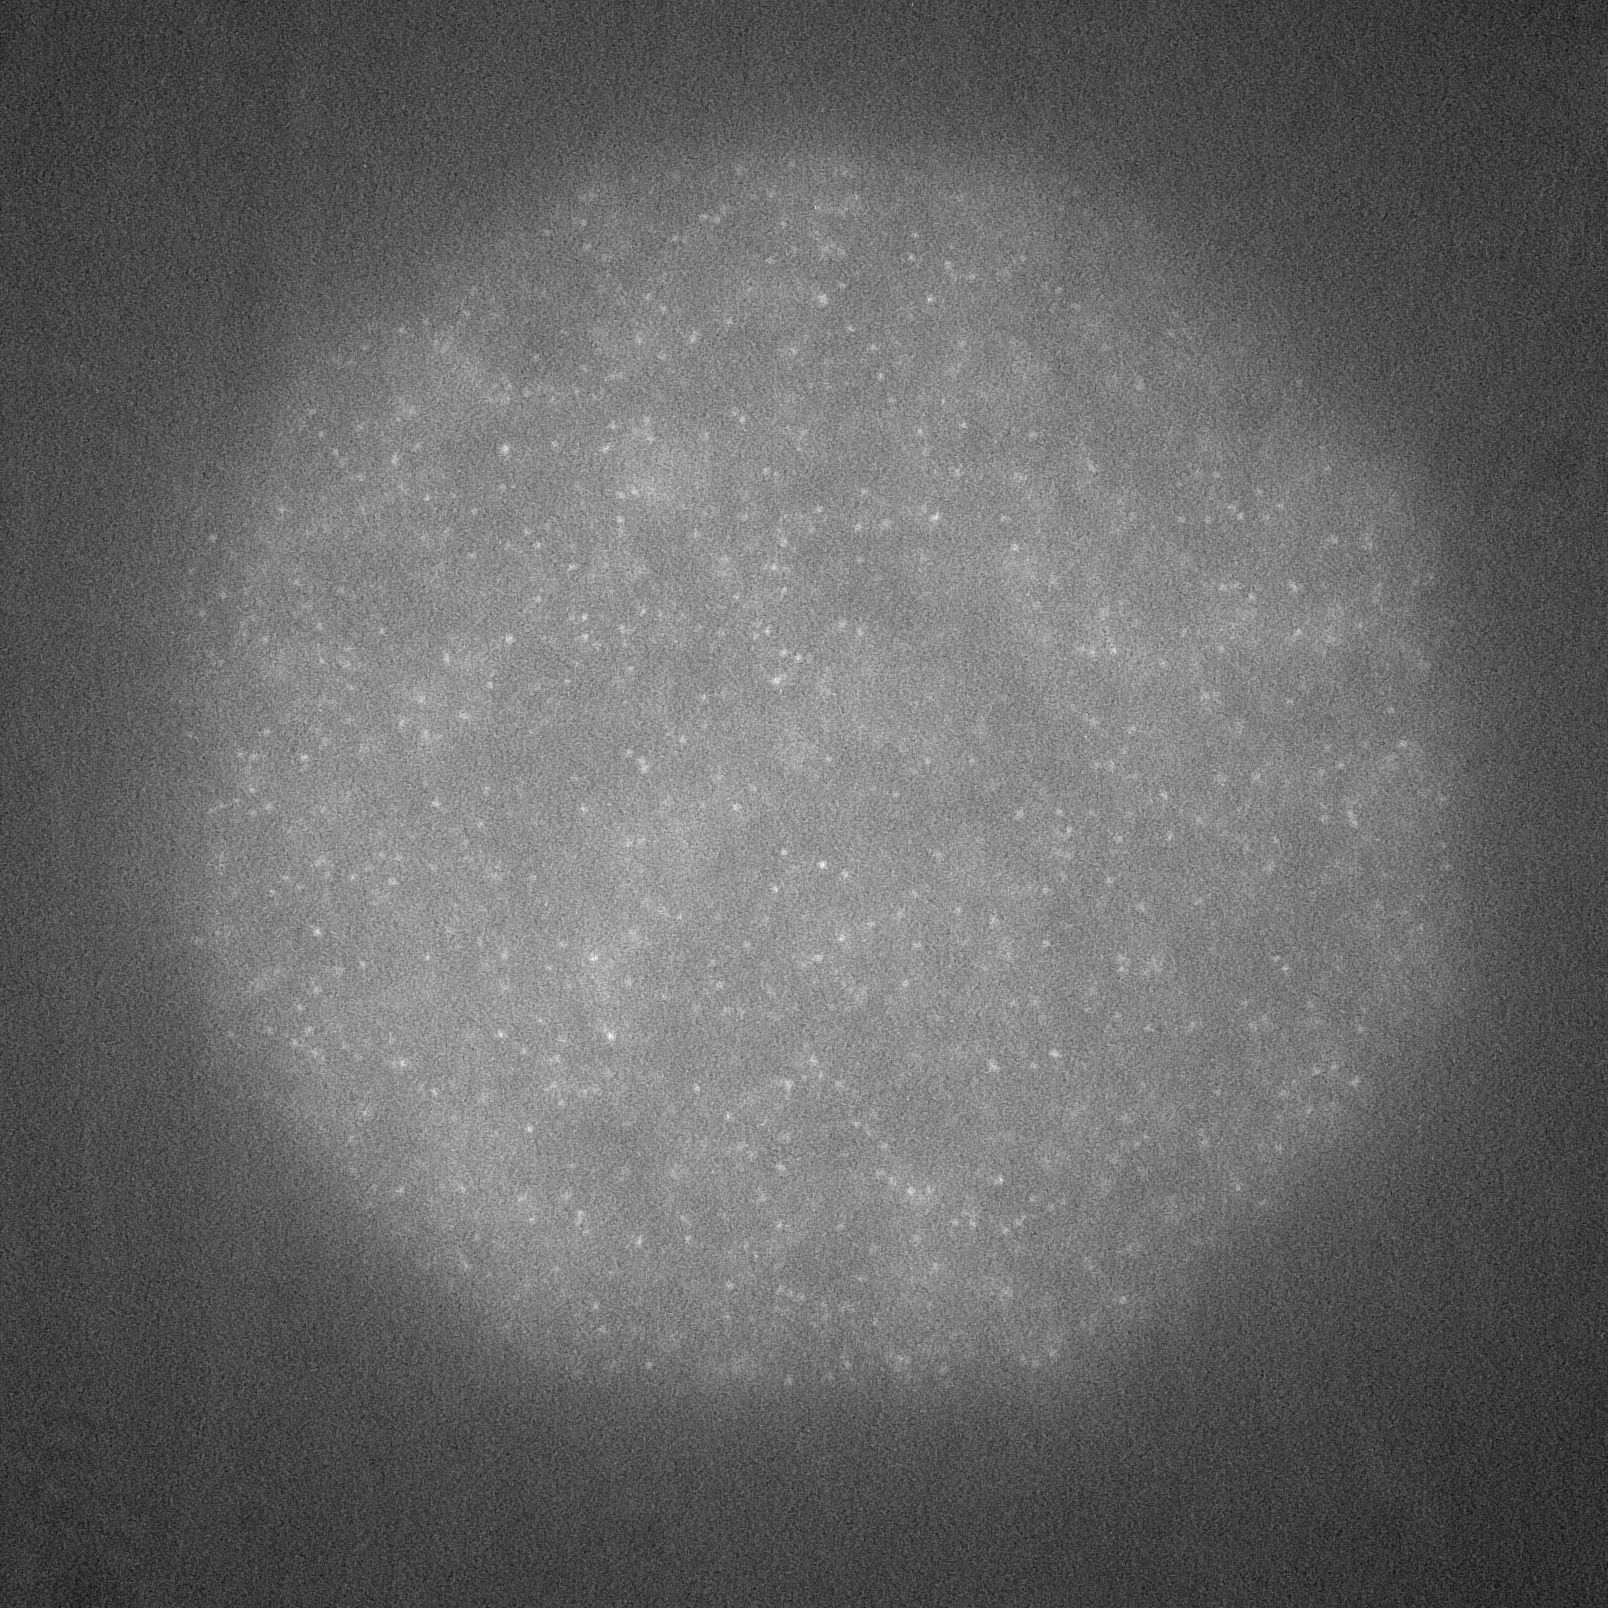

In [3]:
png_data = bytearray(image_width * image_height)
for y in range(0, image_height):
    for x in range(0, image_width):
        png_data[x + y * image_width] = 255 * (raw16[x + y * image_width] - display_range[0]) // (display_range[1] - display_range[0])
w = png.Writer(image_width, image_height, greyscale=True, bitdepth=8)
with open(file_name + '.png', 'wb') as fd:
    w.write(fd, [png_data[i:i + image_width] for i in range(0, len(png_data), image_width)])
display.Image(file_name + '.png')

### Load labels

In [4]:
labels_file_name = 'project-1-at-2023-04-20-19-41-0018c286.json'
with open(labels_file_name, 'r') as fd:
    labels_file = json.load(fd)
for task in labels_file:
    if task['img'].find(file_name_core) >= 0:
        break
else:
    raise 'Cannot find labels for image'
point_labels = task['point']
noise_labels = task['noise']
print('point_labels', len(point_labels))
print('noise_labels', len(noise_labels))

point_labels 325
noise_labels 239


### Generate learning datasets

In [5]:
box_size = 48
display_range_min_vect = np.fromiter([display_range[0]] * box_size, dtype=np.float32)
display_range_diff_vect = np.fromiter([display_range[1]] * box_size, dtype=np.float32) - display_range_min_vect

def tensor_from_location(x, y):
    if (x < box_size // 2) or (y < box_size // 2):
        return None
    offset = x - box_size // 2 + (y - box_size // 2) * image_width
    box_list = [(raw16[offset + yy * image_width:offset + box_size + yy * image_width] - display_range_min_vect) / display_range_diff_vect for yy in range(box_size)]
    return tf.constant(box_list, dtype=tf.float32)

def tensor_set_from_location(x, y):
    result = []
    offset_x = 0
    offset_y = 0
    step_x = 2
    step_y = 2
    for xx in range(-box_size // 8 + offset_x, box_size // 8 + 1, step_x):
        for yy in range(-box_size // 8 + offset_y, box_size // 8 + 1, step_y):
            a = tensor_from_location(x + xx, y + yy)
            if a is None: continue
            shape = a.shape
            orig = tf.reshape(a, shape + (1,))
            mirr = tf.reverse(orig, [0])
            mirr180 = tf.reverse(orig, [1])
            orig180 = tf.reverse(orig, [0, 1])
            orig90, orig270, mirr90, mirr270 = tf.image.rot90((orig, orig180, mirr, mirr180))
            result.append(a)
            result.append(tf.reshape(mirr, shape))
            result.append(tf.reshape(mirr180, shape))
            result.append(tf.reshape(orig180, shape))
            result.append(tf.reshape(orig90, shape))
            result.append(tf.reshape(mirr90, shape))
            result.append(tf.reshape(mirr270, shape))
            result.append(tf.reshape(orig270, shape))
    return result

def get_point_type(x, y, select_count, total_count):
    p = x + y * image_width
    p = ((p >> 16) ^ p) * 0x45d9f3b
    p = ((p >> 16) ^ p) * 0x9372d81
    p = ((p >> 16) ^ p) * 0x45d9f3b
    p = (p >> 16) ^ p
    return p % total_count < select_count

def dataset_from_points(points, label):
    for i in range(len(points)):
        point = points[i]
        x = round(point['x'] * point['original_width'] / 100)
        y = round(point['y'] * point['original_height'] / 100)
        is_test = get_point_type(x, y, 1, 6)
        inputs = test_inputs if is_test else train_inputs
        labels = test_labels if is_test else train_labels
        tensors = tensor_set_from_location(x, y)
        inputs.extend(tensors)
        labels.extend([label] * len(tensors))
        print(f'\r{i+1} of {len(points)}, total {len(train_inputs) + len(test_inputs)}', end='', flush=True)
    print('\n')

def shuffle_pairs(a, b):
    reorder = list(range(0, len(a)))
    random.shuffle(reorder)
    for i in range(len(a)):
        j = reorder[i]
        a[i], a[j] = (a[j], a[i])
        b[i], b[j] = (b[j], b[i])

train_inputs = []
train_labels = []
test_inputs = []
test_labels = []

print('Generating points dataset:')
random.shuffle(point_labels)
dataset_from_points(point_labels, 1)

print('Generating noise dataset:')
random.shuffle(noise_labels)
dataset_from_points(noise_labels, 0)

shuffle_pairs(train_inputs, train_labels)
shuffle_pairs(test_inputs, test_labels)

print('Train dataset', len(train_inputs))
print('Test dataset', len(test_inputs))

test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)
test_inputs = tf.convert_to_tensor(test_inputs)
train_inputs = tf.convert_to_tensor(train_inputs)


Generating points dataset:
325 of 325, total 127400

Generating noise dataset:
239 of 239, total 221088

Train dataset 186200
Test dataset 34888


2023-04-21 20:22:29.634419: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1716019200 exceeds 10% of free system memory.


### Show samples

1


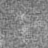

In [183]:
_sample_index = 1
def show_sample(tensor, label, border=False):
    global _sample_index
    _sample_index += 1
    png_data = bytearray(box_size * box_size)
    raw = tf.get_static_value(tensor)
    for y in range(0, box_size):
        for x in range(0, box_size):
            if border and (x == 11 or x == 36 or y == 11 or y == 36):
                png_data[x + y * box_size] = 90
            else:
                png_data[x + y * box_size] = round(255 * raw[y][x])
    w = png.Writer(box_size, box_size, greyscale=True, bitdepth=8)
    with open(f'sample{_sample_index}.png', 'wb') as fd:
        w.write(fd, [png_data[i:i + box_size] for i in range(0, len(png_data), box_size)])
    print(tf.get_static_value(label))
    return display.Image(f'sample{_sample_index}.png')

i = random.randint(0, len(train_inputs) - 1)
show_sample(train_inputs[i], train_labels[i])


### Create model

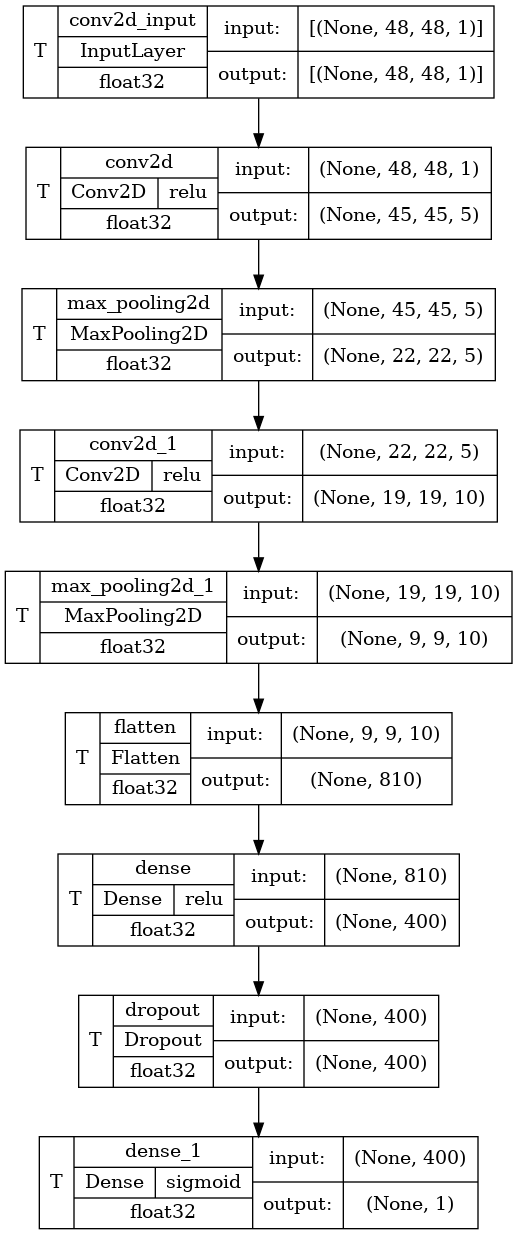

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(5, 4, activation='relu', input_shape=(box_size, box_size, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(10, 4, activation='relu', input_shape=(box_size, box_size, 1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(400, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]
              )

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, show_trainable=True)
display.Image(f'model.png')

In [8]:
model_file_name = './models/model-800715747686-iter-1.tf'
if Path(model_file_name + '.index').exists():
  model.load_weights(model_file_name)
  print('Model loaded')
else:
  print('Model does not exists')

Model loaded


In [ ]:
uuid = f'{random.randint(100000, 999999)}{random.randint(100000, 999999)}'
for i in range(3):
    print(f'Epoch {i+1}:')
    model.fit(train_inputs, train_labels, batch_size=100)
    loss, acc, _, _ = model.evaluate(test_inputs, test_labels, batch_size=1000)
    model_file_name = f'./models/model-{uuid}-iter-{i}-{acc * 100}.tf'
    model.save_weights(model_file_name)


In [9]:
loss, acc, _, _ = model.evaluate(test_inputs, test_labels, batch_size=1000)

35/35 [==============================] - 5s 119ms/step - loss: 0.0341 - binary_accuracy: 0.9862 - false_negatives: 159.0000 - false_positives: 322.0000


In [10]:
res = model(test_inputs)

2023-04-21 20:23:10.774604: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1412964000 exceeds 10% of free system memory.
2023-04-21 20:23:13.093173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1412964000 exceeds 10% of free system memory.
2023-04-21 20:23:13.760096: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1412964000 exceeds 10% of free system memory.


Result:  1
1


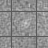

In [267]:
res_arr = tf.reshape(res, (res.shape[0],)).numpy()
labels_arr = tf.reshape(test_labels, (test_labels.shape[0],)).numpy()
diff = res_arr - labels_arr
start = random.randint(0, len(diff))
for i in range(start, len(diff)):
    if diff[i] < -0.5:
        #print(i, -0.5 - diff[i])
        break
    if diff[i] > 0.5:
        #print(i, diff[i] - 0.5)
        break
else:
    print('retry')

i = random.randint(0, len(diff))
print('Result: ', round(res_arr[i]))
show_sample(test_inputs[i], test_labels[i], True)


In [ ]:
model_reg = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(5, 4, activation='relu', input_shape=(box_size, box_size, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(10, 4, activation='relu', input_shape=(box_size, box_size, 1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(400, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(2, activation='linear')
])

model.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()]
              )

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True, show_trainable=True)
display.Image(f'model.png')